In [1]:
!pip install gdown

In [2]:
!gdown 1nm_4qEHQ0iSKnpPT3hu1i0fNuTpUx-J8

Downloading...
From (uriginal): https://drive.google.com/uc?id=1nm_4qEHQ0iSKnpPT3hu1i0fNuTpUx-J8
From (redirected): https://drive.google.com/uc?id=1nm_4qEHQ0iSKnpPT3hu1i0fNuTpUx-J8&confirm=t&uuid=6e60073b-e09c-4615-b221-8b1f4b7921ee
To: /kaggle/working/Dataset.zip
100%|█████████████████████████████████████████| 533M/533M [00:02<00:00, 258MB/s]


In [3]:
!ls

Dataset.zip  __notebook_source__.ipynb


In [4]:
!unzip Dataset.zip

Archive:  Dataset.zip
   creating: Dataset/
  inflating: Dataset/.DS_Store       
  inflating: __MACOSX/Dataset/._.DS_Store  
   creating: Dataset/HR/
   creating: Dataset/LR/
  inflating: Dataset/HR/sample104.npy  
  inflating: Dataset/HR/sample1964.npy  
  inflating: Dataset/HR/sample8798.npy  
  inflating: Dataset/HR/sample8940.npy  
  inflating: Dataset/HR/sample662.npy  
  inflating: Dataset/HR/sample9486.npy  
  inflating: Dataset/HR/sample3815.npy  
  inflating: Dataset/HR/sample3801.npy  
  inflating: Dataset/HR/sample6979.npy  
  inflating: Dataset/HR/sample676.npy  
  inflating: Dataset/HR/sample8954.npy  
  inflating: Dataset/HR/sample9492.npy  
  inflating: Dataset/HR/sample110.npy  
  inflating: Dataset/HR/sample1970.npy  
  inflating: Dataset/HR/sample4808.npy  
  inflating: Dataset/HR/sample138.npy  
  inflating: Dataset/HR/sample1780.npy  
  inflating: Dataset/HR/sample1958.npy  
  inflating: Dataset/HR/sample3197.npy  
  inflating: Dataset/HR/sample2289.npy  
  inflati

In [5]:
!ls Dataset

HR  LR


In [6]:
source_dir = "Dataset/"
dest_dir = "New_Dataset/"

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
import os

# Load HR and LR images with .npy extension
hr_images = np.array([np.load(os.path.join('Dataset', 'HR', file)) for file in os.listdir(os.path.join('Dataset', 'HR'))])
lr_images = np.array([np.load(os.path.join('Dataset', 'LR', file)) for file in os.listdir(os.path.join('Dataset', 'LR'))])

# Split into training and validation sets
train_hr, val_hr, train_lr, val_lr = train_test_split(hr_images, lr_images, test_size=0.1, random_state=42)

# Preprocess the data
train_hr_proc = np.squeeze(train_hr)
val_hr_proc = np.squeeze(val_hr)
train_lr_proc = np.squeeze(train_lr)
val_lr_proc = np.squeeze(val_lr)

# Reshape the data to the format (batch, height, width, channel)
train_hr_proc = np.expand_dims(train_hr_proc, axis=-1)
val_hr_proc = np.expand_dims(val_hr_proc, axis=-1)
train_lr_proc = np.expand_dims(train_lr_proc, axis=-1)
val_lr_proc = np.expand_dims(val_lr_proc, axis=-1)

print(train_hr_proc.shape, val_hr_proc.shape, train_lr_proc.shape, val_lr_proc.shape)

(9000, 150, 150, 1) (1000, 150, 150, 1) (9000, 75, 75, 1) (1000, 75, 75, 1)


In [8]:
import tensorflow as tf
import glob
import keras
import keras.backend as K
from keras.optimizers import Adam
from keras.applications import VGG19
from keras.losses import MeanSquaredError
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv2D, UpSampling2D, Conv2DTranspose, Input, ReLU, Add, Lambda, Activation, LeakyReLU, BatchNormalization, Dense, Flatten, GlobalAveragePooling2D, Concatenate, Layer


# def super_res_cnn():
#     # define input shape
#     input_shape = (75, 75, 1)
#     input_layer = tf.keras.layers.Input(shape=input_shape)
    
#     # add convolutional layers
#     x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(input_layer)
#     x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
#     x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    
#     # add upsampling layers
#     x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(x)
#     x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
#     x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, padding='same')(x)
    
#     # define output layer
#     output_layer = x
    
#     # create and compile model
#     model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
#     model.compile(optimizer='adam', loss='mse')
    
#     return model

def super_res_cnn():
    model = Sequential([
        UpSampling2D(size=(2, 2), input_shape=(75, 75, 1)),
        Conv2D(1024, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (1, 1), activation='relu', padding='same'),
        Conv2D(1, (3, 3), activation='linear', padding='same')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse', 'mae', 'accuracy'])
    return model


In [9]:
# Split into training and validation sets
train_hr, val_hr, train_lr, val_lr = train_test_split(hr_images, lr_images, test_size=0.1, random_state=42) # (None, 1, x, x)

# Preprocess the data
train_hr, val_hr, train_lr, val_lr = np.squeeze(train_hr), np.squeeze(val_hr), np.squeeze(train_lr), np.squeeze(val_lr) # (None, x, x)

# Reshape the data to the format (batch, height, width, channel)
train_hr, val_hr = train_hr[..., np.newaxis], val_hr[..., np.newaxis] # (None, x, x, 1)
train_lr, val_lr = train_lr[..., np.newaxis], val_lr[..., np.newaxis]

print(train_hr.shape, val_hr.shape, train_lr.shape, val_lr.shape)

(9000, 150, 150, 1) (1000, 150, 150, 1) (9000, 75, 75, 1) (1000, 75, 75, 1)


In [10]:
# create and compile model
model = super_res_cnn()

In [11]:
# train model
history = model.fit(train_lr, train_hr, validation_data=(val_lr, val_hr), epochs=10, batch_size=8)

Epoch 1/10
1125/1125 [==============================] - 289s 247ms/step - loss: 9.8217e-05 - mse: 9.8217e-05 - mae: 0.0054 - accuracy: 1.8846e-04 - val_loss: 6.0533e-05 - val_mse: 6.0533e-05 - val_mae: 0.0050 - val_accuracy: 1.9107e-04
Epoch 2/10
1125/1125 [==============================] - 286s 254ms/step - loss: 6.1308e-05 - mse: 6.1308e-05 - mae: 0.0050 - accuracy: 1.8854e-04 - val_loss: 5.9987e-05 - val_mse: 5.9987e-05 - val_mae: 0.0049 - val_accuracy: 1.9107e-04
Epoch 3/10
1125/1125 [==============================] - 295s 262ms/step - loss: 6.1572e-05 - mse: 6.1572e-05 - mae: 0.0050 - accuracy: 1.8854e-04 - val_loss: 6.1416e-05 - val_mse: 6.1416e-05 - val_mae: 0.0050 - val_accuracy: 1.9107e-04
Epoch 4/10
1125/1125 [==============================] - 294s 261ms/step - loss: 6.3259e-05 - mse: 6.3259e-05 - mae: 0.0050 - accuracy: 1.8854e-04 - val_loss: 5.9808e-05 - val_mse: 5.9808e-05 - val_mae: 0.0049 - val_accuracy: 1.9107e-04
Epoch 5/10
1125/1125 [==============================] - 

In [12]:
model.save('model1.h5')

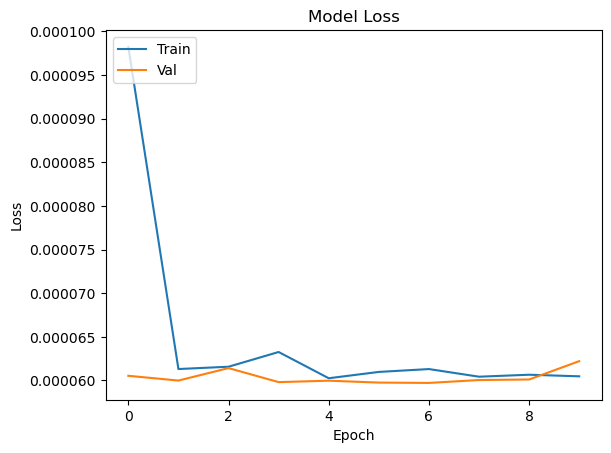

In [17]:
import matplotlib.pyplot as plt
#visualize the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


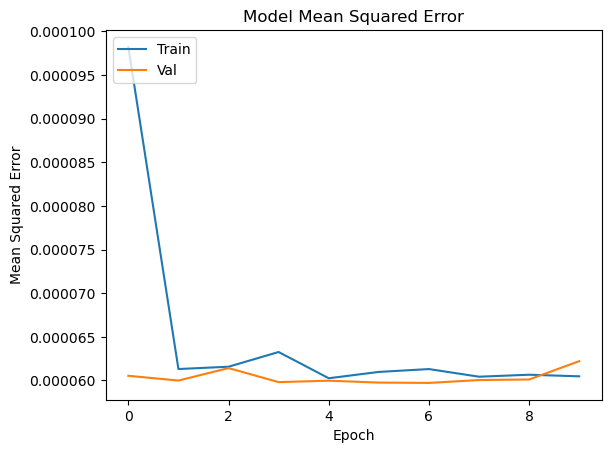

In [19]:
#visualize the training and validation mean squared error
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model Mean Squared Error')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

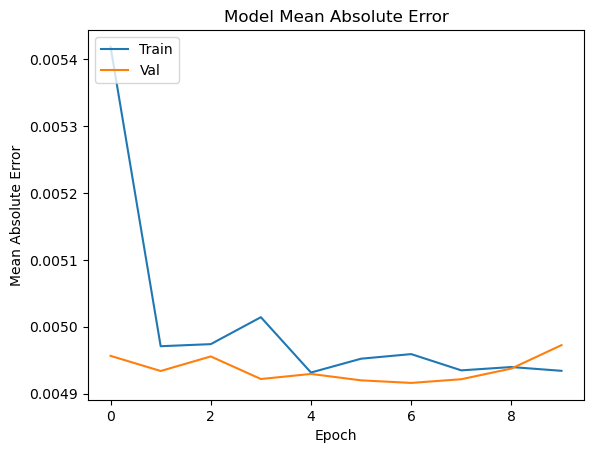

In [20]:
#visualize the training and validation mean squared error
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

32/32 [==============================] - 12s 263ms/step


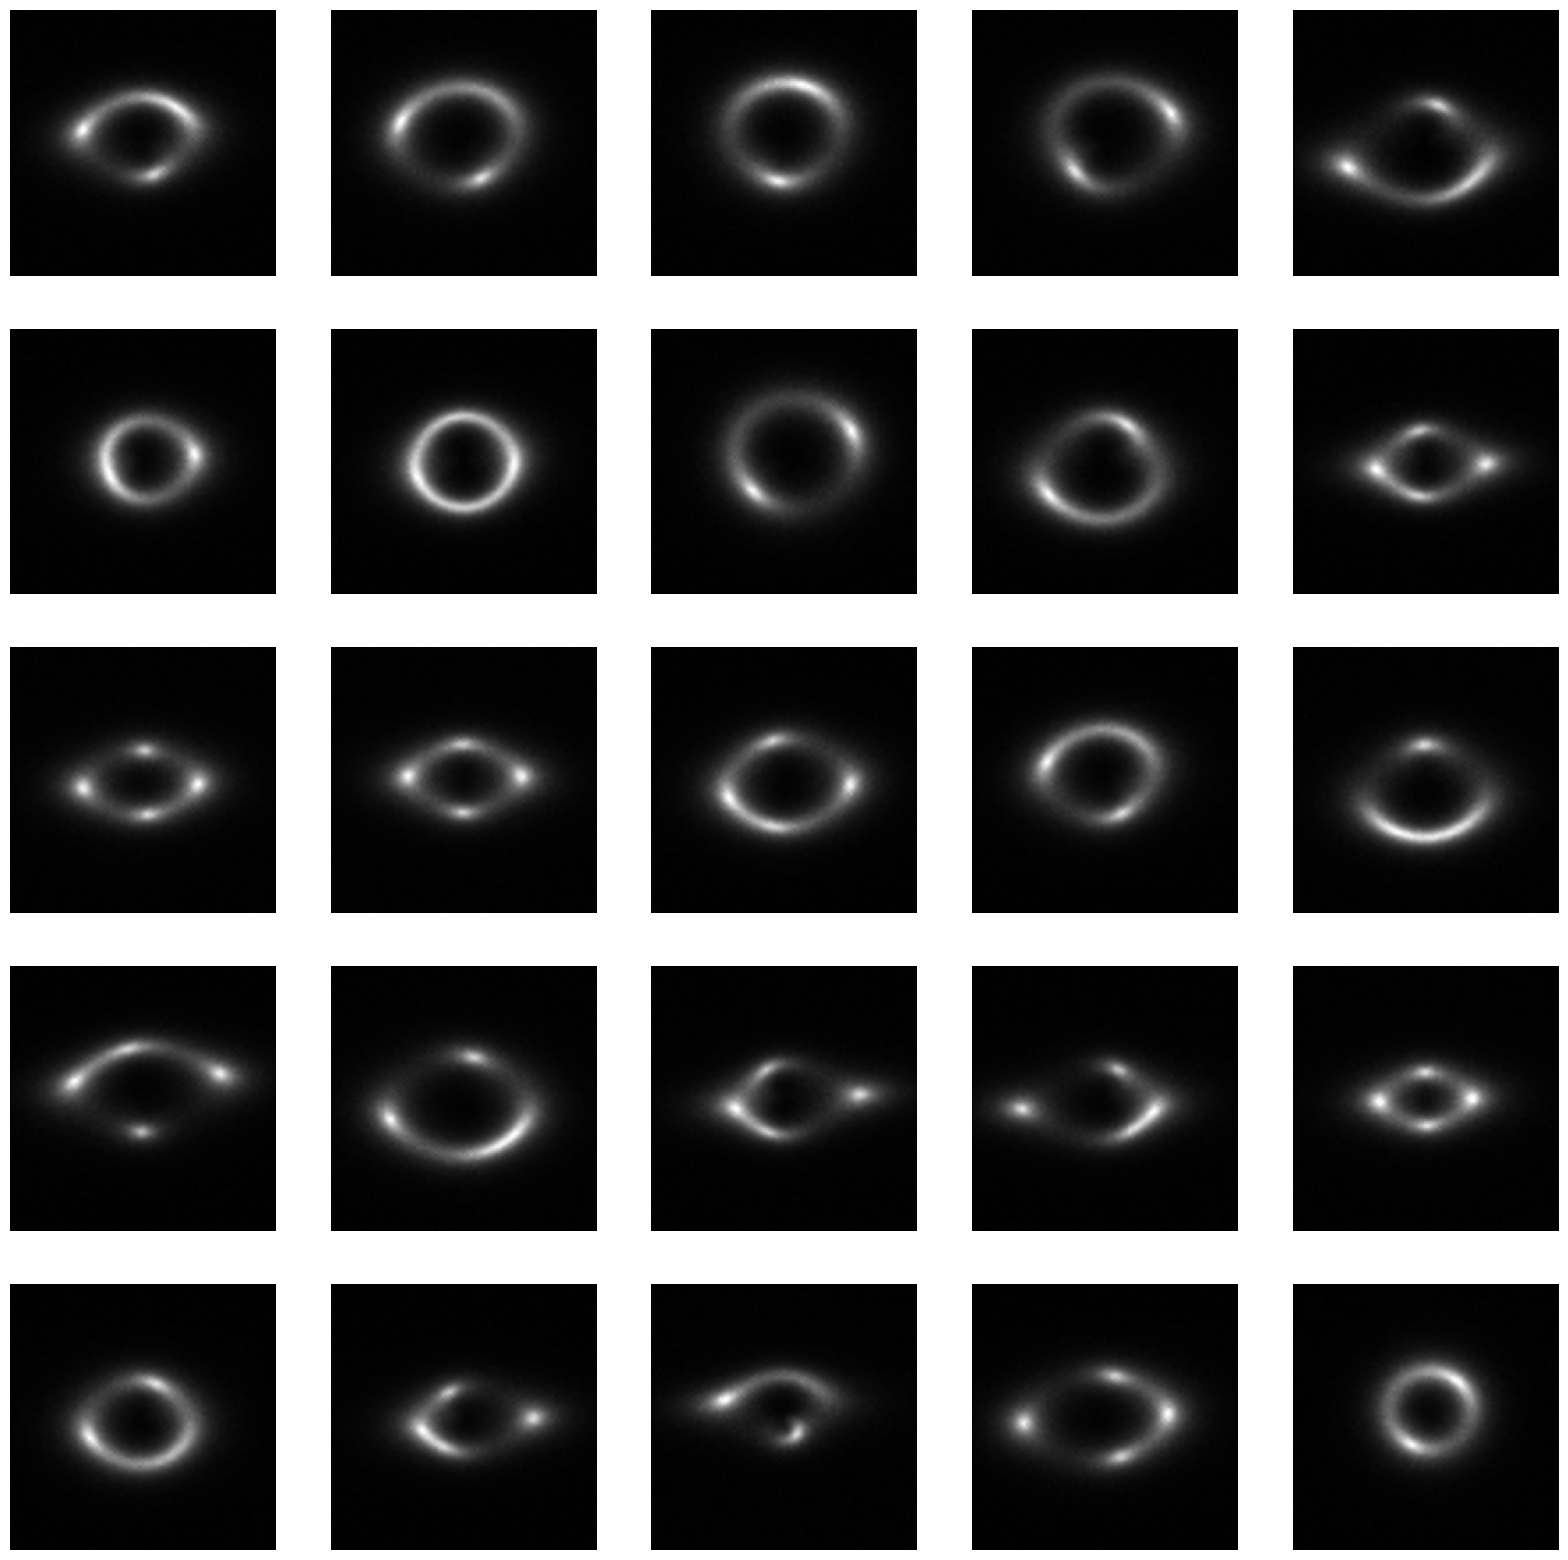

In [25]:
# Load the model
model = load_model('model1.h5')

# Evaluate the model
model.evaluate(val_lr)

# Make predictions
predictions = model.predict(val_lr)

# Visualize the predictions
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()
